<a href="https://colab.research.google.com/github/RCortez25/PhD/blob/main/LLM/4.%20Attention%20mechanism/0_Simplified_attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The importance that the model gives to a certain word is given by the attention weights.


Self-attention is the key component of modern LLMs. The "self" refers to the ability to compute attention weights by relationg different positions of the same input. Traditional attention mechanisms focus on relationships between elements in different sequences (like input and output).

The goal: Calculate a context vector $z^{(i)}$ for each input vector $x^{(i)}$. This context vector is an enriched version of each input vector which contains information about relationships of tokens.
___

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the inpur tensors
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3)
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x^6)
)

Let's plot the word into the 3-dimensional space corresponding to this example

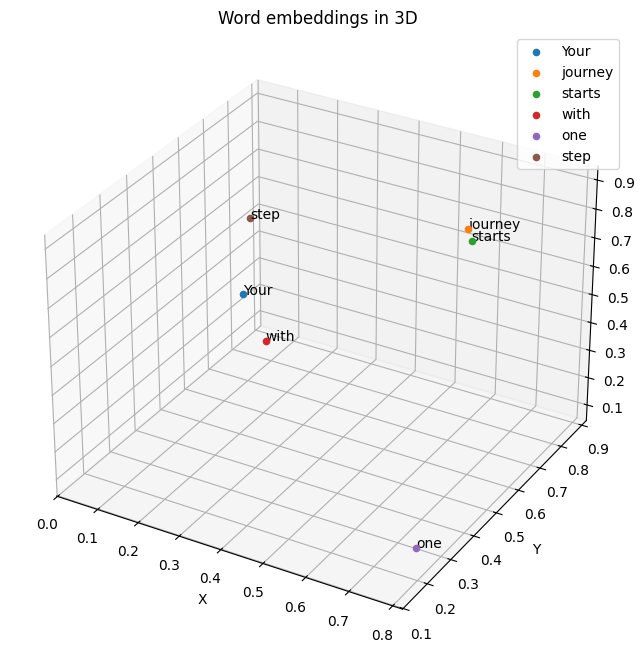

In [2]:
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Get the x, y, and z coordinates for each vector

x_coordinates = inputs[:, 0].numpy()
y_coordinates = inputs[:, 1].numpy()
z_coordinates = inputs[:, 2].numpy()

# Plot the vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, word in zip(x_coordinates, y_coordinates, z_coordinates, words):
    ax.scatter(x, y, z, label=word)
    ax.text(x, y, z, word)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.title('Word embeddings in 3D')
plt.show()

Now, let's show the vectors

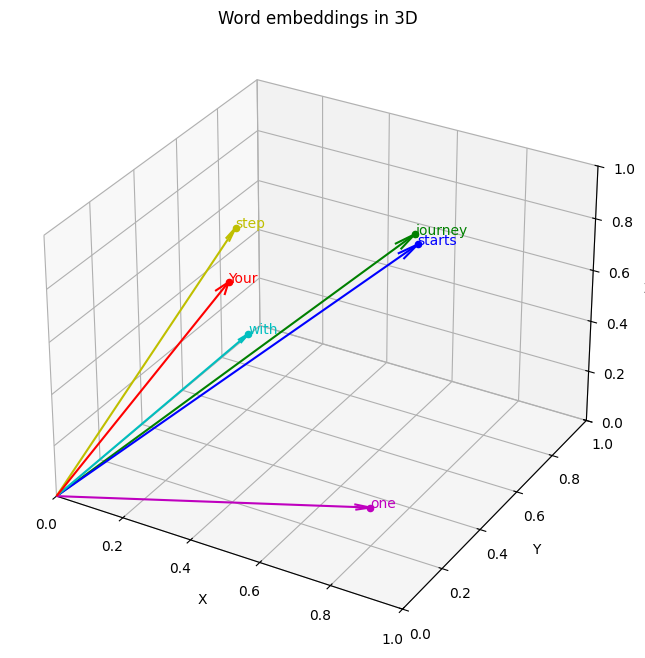

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coordinates, y_coordinates, z_coordinates, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.scatter(x, y, z, color=color)
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('Word embeddings in 3D')
plt.show()

## Calculate context vector for "journey"

In this case, "journey" corresponds to $x^{(2)}$, and this is called the **query**. The query is the current vector one is focusing on for calculating its context vector $z^{(i)}$.

Recall that the context vector $z^{(2)}$ will contain information about $x^{(2)}$ and all other vectors $x^{(i)}$.

The first step in calculating $z^{(2)}$ is to calculate **attention scores** between the query $x^{(2)}$ and all other $x^{(i)}$. One writes, in this case, for the attention scores:

- $\omega_{21}$ for the attention score between $x^{(2)}$ and $x^{(1)}$. Note that the query is the first index.
- $\omega_{22}$ for the attention score between $x^{(2)}$ and $x^{(2)}$. Indeed, an attention score is calculated for the query and itself.
- $\omega_{23}$ for the attention score between $x^{(2)}$ and $x^{(3)}$.

and so on.

Now, how does one calculate the attention scores? With a dot product. Higher dot product means higher similarity.

In [4]:
# Select the current query
query = inputs[1] # The word "journey"

# Create a placeholder to store the attention scores for this particular query
# This genetares a tensor with 6 entries, one for each input vector
attention_scores_query_2 = torch.empty(inputs.shape[0])

# Calculate the attention scores for this query
for i, x_i in enumerate(inputs):
    # Populate the placeholder with the calculated dot products
    attention_scores_query_2[i] = torch.dot(query, x_i)

# Check the results
attention_scores_query_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

In [5]:
# Checking each result individually
for i, result in enumerate(attention_scores_query_2):
    print(f'The attention score between vector x_{i} and the query x_2 is: {result}')

The attention score between vector x_0 and the query x_2 is: 0.9544000625610352
The attention score between vector x_1 and the query x_2 is: 1.4950001239776611
The attention score between vector x_2 and the query x_2 is: 1.4754000902175903
The attention score between vector x_3 and the query x_2 is: 0.8434000015258789
The attention score between vector x_4 and the query x_2 is: 0.7070000171661377
The attention score between vector x_5 and the query x_2 is: 1.0865000486373901


The next step is to normalize the results in order to make them more interpretable. These normalized attention scores are termed **attention weights** $\alpha$. One will have $\omega_{21}\rightarrow\alpha_{21}$ and so on. One can interpret these as precentages of importance to the given query.

Moreover, this helps with the training phase of the LLM.

In [6]:
# One way to achieve normalization
normalized_attention_scores_query_2_temporal = attention_scores_query_2 / torch.sum(attention_scores_query_2)
print(f'Normalized attention scores: {normalized_attention_scores_query_2_temporal}')
print(f'Sum of normalized attention scores: {torch.sum(normalized_attention_scores_query_2_temporal)}')

Normalized attention scores: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum of normalized attention scores: 1.0000001192092896


The way to do it is to use the _softmax_ function.

In [7]:
attention_weights_query_2 = torch.nn.functional.softmax(attention_scores_query_2, dim=0)
print(f'Attention weights: {attention_weights_query_2}')
print(f'Sum of attention weights: {torch.sum(attention_weights_query_2)}')

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum of attention weights: 1.0


As can be seen, this gives more stability and is better for optimization and training. Roughly speaking, one can think of $\alpha_{21}=0.1385$ as approximately representing 13% of similarity or importance between "Your" and "journey".

That is, the precentage of each input vector is the importance that vector carries with respecto to the given query.
___
The context vector $z^{(i)}$ is calculated as follows:
- Take each original input vector
- Scale each one by the corresponding attention weight
- Add them up
- The resulting vector is the context vector for the current query
___

In [8]:
# Calculate context vector for query x^2 corresponding to " journey"
# Create a placeholder for the context vector
# The context vector is of the same dimension as the original input vectors
context_vector_query_2 = torch.zeros(query.shape)

# Calculate the context vector by multiplying each by its attention weight
for i, x_i in enumerate(inputs):
    context_vector_query_2 += attention_weights_query_2[i] * x_i

# Check the results
context_vector_query_2

tensor([0.4419, 0.6515, 0.5683])

Now, let's plot the newly created context vector

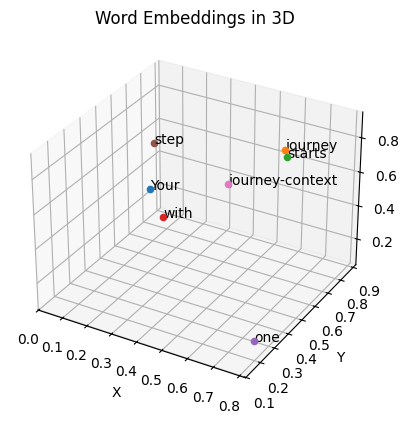

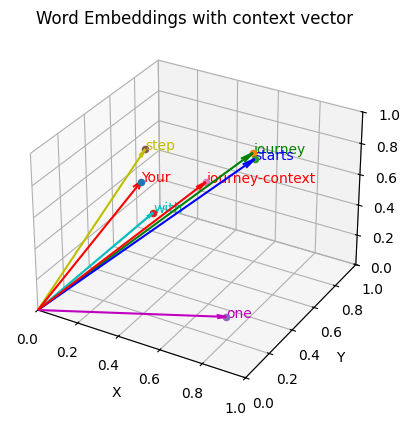

In [14]:
# Add the context vector to inputs, just for plotting it
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]] # Context vector z^2
)

# Corresponding words and context vector for plotting
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates again to take into account the context vector
x_coordinates = inputs[:, 0].numpy()
y_coordinates = inputs[:, 1].numpy()
z_coordinates = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coordinates, y_coordinates, z_coordinates, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Word Embeddings in 3D')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coordinates, y_coordinates, z_coordinates, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('Word Embeddings with context vector')
plt.show()

So, we have calculated the context vector for the query $x^{(2)}$. Now, let's calculate the context vectors for all inputs at once.

In [30]:
# Reset the input variable to not contain the journey-context vector
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts   (x^3)
     [0.22, 0.58, 0.33], # with     (x^4)
     [0.77, 0.25, 0.10], # one      (x^5)
     [0.05, 0.80, 0.55]] # step     (x^6)
)

# Compute attention scores. Note the usage of the transpose of the inputs matrix
attention_scores = torch.matmul(inputs, inputs.T)

# Normalize attention scores
# dim=-1 ensures we normalize by traversing the columns, which will amount to
# normalizing for each row. This is becase -1 means the last dimension, and if
# the tensor was of dimensionality higher than 3 one must calculate along the
# last dimension
attention_weights = torch.softmax(attention_scores, dim=-1)

# Check that the results so far sum up to 1
attention_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [33]:
# Calculate context vectors. Note that in this case, the transpose is not
# neccessary
context_vectors = torch.matmul(attention_weights, inputs)

# Check the results
context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

Each row corresponds to a context vector $z^ {(i)}$ for each input vector $x^{(i)}$. As can be seen, the second context vector is equal to the context vector we calculated in isolation before.

In [35]:
# Print the previously calculated context vector z^2
print(f'Context vector z^2: {context_vector_query_2}')

Context vector z^2: tensor([0.4419, 0.6515, 0.5683])


Now, we need trainable weights in order to capture more naunces of the sentences. Trainable weights allow the model to capture more long-range dependencies.